In [1]:
import os
from datetime import datetime
#from datetime import date``
import pymysql
from sqlalchemy import create_engine, text
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
from numpy import int16
from enum import Enum
from dataframe_image import export
from datetime import datetime


In [2]:
# Using enum class create enumerations
class Constante(Enum):
   glob = ""
   specific = "2024-01-01"
   end = datetime.today().strftime("%Y-%m-%d")


In [3]:
load_dotenv("../actual_caris_host.env")
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')
# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    agent_username, COUNT(*) AS nbre,
    dsd.organisation,
    dsd.timeEnd as entry_date
FROM
    caris_db.dreams_surveys_data dsd
WHERE
    dsd.timeEnd >= '{Constante.specific.value}'
    and
    dsd.timeEnd <= '{Constante.end.value}'
GROUP BY agent_username
'''
agent = pd.read_sql_query(text(query),engine.connect(),parse_dates=True)
# get the test excel file from Query
# close the pool of connection
engine.dispose()


## Agent DREAMS sortant du Systeme

In [4]:
agent.rename(columns={'agent_username':'username'},inplace=True)


In [5]:
agent


,username,nbre,organisation,entry_date
0,2jules,47,Caris,2024-02-26 19:58:40
1,1mondesir,516,Caris,2024-03-07 12:41:31
2,1pierre,668,Caris,2024-03-13 18:40:19
3,2fabrice,136,Caris,2024-01-12 20:57:02
4,cmariedanielle,86,Caris,2024-02-27 15:41:08
5,1targie,86,Caris,2024-03-03 19:11:22
6,6chelot,167,Caris,2024-03-09 16:03:45
7,s2natalie,28,Caris,2024-02-27 13:31:01
8,1jeanelie,57,Caris,2024-03-01 17:16:03
9,2gerald,81,Caris,2024-02-26 16:43:33


In [6]:
agent_name = pd.read_excel("caris-test_users_48427203a28d49ffa90cba1a8d5f2ff6.xlsx")
agent_past_data = pd.read_excel("performance_formulaire_denrolement.xlsx")


In [7]:
agent_name = agent_name[["username","name"]]


## Liste de tous les agents avec Leur nom

In [8]:
agent_name


,username,name
0,1aldonzar,elcie aldonzar
1,1annuelle,Annuelle Eustache
2,1blenzaire,Blenzaire Etienne
3,1bycinthe,Roberthe Bycinthe
4,1chrislyne,Chrislyne Bien Aimée
...,...,...
865,vvillard,Vilner Villard
866,wbeauplan,Willins Beauplan
867,yandre,Yves Andre
868,yvon,Yvon Antoine


In [9]:
agent_name = agent_name.merge(agent,on="username",how="inner")

In [10]:
agent_name.sort_values(by=['nbre'],ascending=False,inplace=True)

In [11]:
agent_name

,username,name,nbre,organisation,entry_date
8,1pierre,Rose Andie Pierre,668,Caris,2024-03-13 18:40:19
6,1mondesir,Elande Mondésir,516,Caris,2024-03-07 12:41:31
21,6chelot,Chelot Demosthene,167,Caris,2024-03-09 16:03:45
10,2billy,Billy jolicoeur,155,Caris,2024-02-15 16:25:02
14,2fabrice,Fabrice Byron,136,Caris,2024-01-12 20:57:02
24,cmariedanielle,Marie Danielle Cazy,86,Caris,2024-02-27 15:41:08
9,1targie,Bazile Yanne Targie,86,Caris,2024-03-03 19:11:22
15,2gerald,Gerald Poteau,81,Caris,2024-02-26 16:43:33
20,2woodridchard,Wood-Ridchard Bon,77,Caris,2024-01-24 16:10:59
12,2diegoarmando,Diego Armando Dorlean,72,Caris,2024-02-26 18:47:51


In [12]:
agent_past_data = agent_past_data[["username","nbre"]]


In [13]:
agent_past_data.rename(columns={'nbre':'past_entry'},inplace=True)


In [14]:
agent_name = agent_name.merge(agent_past_data,on="username",how="left")
agent_name.fillna(0,inplace=True)


In [15]:
agent_name['nbre_new_entry'] = agent_name['nbre'] - agent_name['past_entry']


In [16]:
agent_name


,username,name,nbre,organisation,entry_date,past_entry,nbre_new_entry
0,1pierre,Rose Andie Pierre,668,Caris,2024-03-13 18:40:19,514.0,154.0
1,1mondesir,Elande Mondésir,516,Caris,2024-03-07 12:41:31,509.0,7.0
2,6chelot,Chelot Demosthene,167,Caris,2024-03-09 16:03:45,167.0,0.0
3,2billy,Billy jolicoeur,155,Caris,2024-02-15 16:25:02,136.0,19.0
4,2fabrice,Fabrice Byron,136,Caris,2024-01-12 20:57:02,136.0,0.0
5,cmariedanielle,Marie Danielle Cazy,86,Caris,2024-02-27 15:41:08,86.0,0.0
6,1targie,Bazile Yanne Targie,86,Caris,2024-03-03 19:11:22,77.0,9.0
7,2gerald,Gerald Poteau,81,Caris,2024-02-26 16:43:33,81.0,0.0
8,2woodridchard,Wood-Ridchard Bon,77,Caris,2024-01-24 16:10:59,77.0,0.0
9,2diegoarmando,Diego Armando Dorlean,72,Caris,2024-02-26 18:47:51,72.0,0.0


In [17]:
agent_name = agent_name[['username','name','nbre','nbre_new_entry','organisation','entry_date']]


In [18]:
agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)


/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_59422/3287235938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)


In [19]:
agent_name


,username,name,nbre,nbre_new_entry,organisation,entry_date
0,1pierre,Rose Andie Pierre,668,154,Caris,2024-03-13 18:40:19
1,1mondesir,Elande Mondésir,516,7,Caris,2024-03-07 12:41:31
2,6chelot,Chelot Demosthene,167,0,Caris,2024-03-09 16:03:45
3,2billy,Billy jolicoeur,155,19,Caris,2024-02-15 16:25:02
4,2fabrice,Fabrice Byron,136,0,Caris,2024-01-12 20:57:02
5,cmariedanielle,Marie Danielle Cazy,86,0,Caris,2024-02-27 15:41:08
6,1targie,Bazile Yanne Targie,86,9,Caris,2024-03-03 19:11:22
7,2gerald,Gerald Poteau,81,0,Caris,2024-02-26 16:43:33
8,2woodridchard,Wood-Ridchard Bon,77,0,Caris,2024-01-24 16:10:59
9,2diegoarmando,Diego Armando Dorlean,72,0,Caris,2024-02-26 18:47:51


## MERGE (Vlookup)

In [20]:
performanceAgents = agent_name


In [21]:
performanceAgents.nbre.sum()


2607

In [22]:
performanceAgents

,username,name,nbre,nbre_new_entry,organisation,entry_date
0,1pierre,Rose Andie Pierre,668,154,Caris,2024-03-13 18:40:19
1,1mondesir,Elande Mondésir,516,7,Caris,2024-03-07 12:41:31
2,6chelot,Chelot Demosthene,167,0,Caris,2024-03-09 16:03:45
3,2billy,Billy jolicoeur,155,19,Caris,2024-02-15 16:25:02
4,2fabrice,Fabrice Byron,136,0,Caris,2024-01-12 20:57:02
5,cmariedanielle,Marie Danielle Cazy,86,0,Caris,2024-02-27 15:41:08
6,1targie,Bazile Yanne Targie,86,9,Caris,2024-03-03 19:11:22
7,2gerald,Gerald Poteau,81,0,Caris,2024-02-26 16:43:33
8,2woodridchard,Wood-Ridchard Bon,77,0,Caris,2024-01-24 16:10:59
9,2diegoarmando,Diego Armando Dorlean,72,0,Caris,2024-02-26 18:47:51


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [24]:
from datetime import datetime
date_du_jour = datetime.today().strftime("%d_%m_%Y")


In [25]:
orderdata = performanceAgents.nbre.sort_values().to_list()


/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_59422/605691686.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)


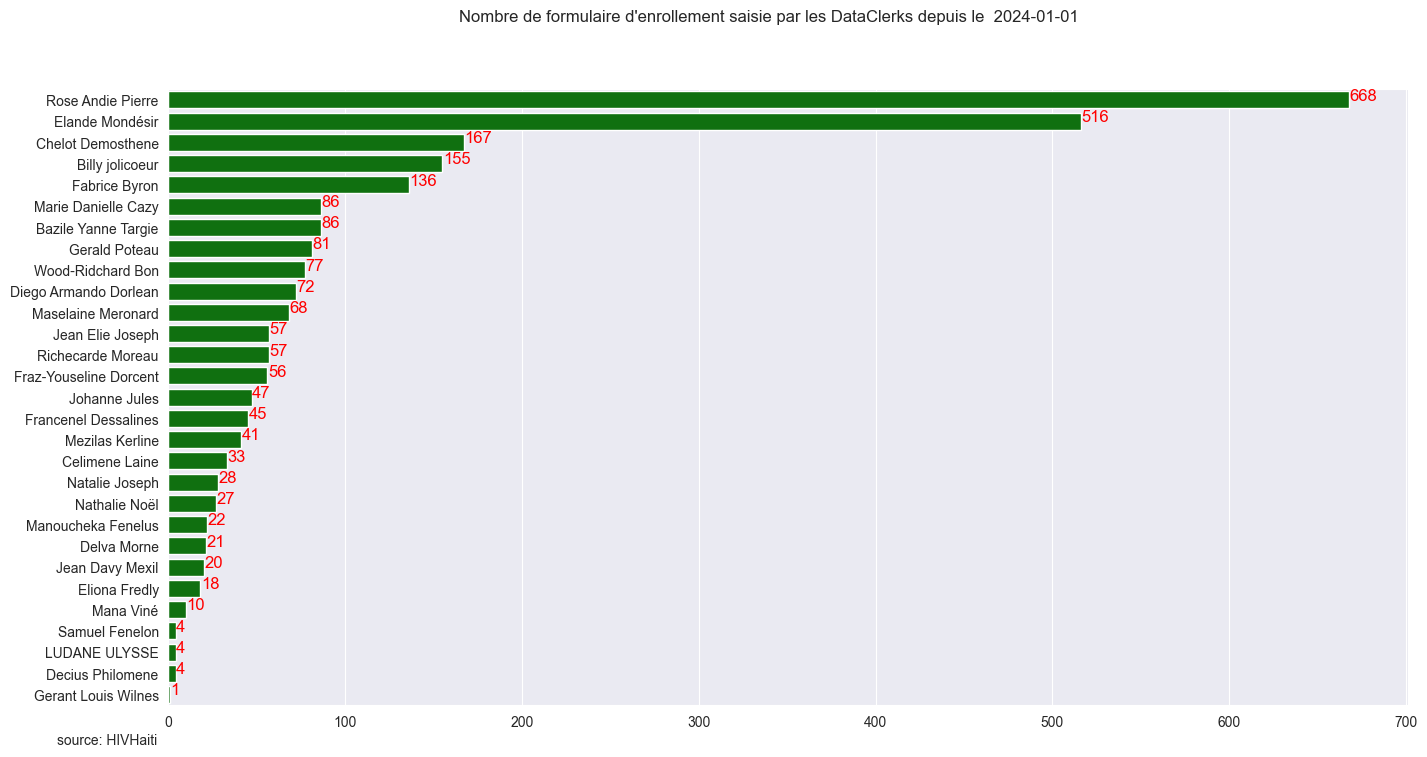

In [26]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de formulaire d'enrollement saisie par les DataClerks depuis le  {Constante.specific.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )

    #plt.savefig(f"saisie_screening_{date_du_jour}",dpi=1000)
except ValueError:
    print("No data is avalaible")


In [27]:
performanceAgents.nbre.sum()


2607

In [28]:
performanceAgents.nbre_new_entry.sum()

258

In [29]:
performanceAgents.to_excel(f"performance_formulaire_denrolement.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_{date_du_jour}.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_depuis_1Mars2021.xlsx",index=False,na_rep="NULL")